In [1]:
#!pip instal hide_code

In [2]:
from collections import Counter
from datetime import datetime, timedelta, date
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

from util.config import versioned
from util.polish import TERYT
from scrapers.pkw.sources import election_date
from analysis.utils import drop_duplicates, read_enriched, extract_companies

In [3]:
teryt = "all"

In [4]:
local_good = read_enriched(None)
print(f"Znaleziono {len(local_good)} osób")

Missing teryt: {'0209', '7910', '1402', '0208', '1431', '4700', '1751', '2602', '1428', '9300', '8321', '4329', '3005', '5966', '1421', '4750', '2204', '1430', '9101', '8924', '0223', '2322', '1932', '2013', '4327', '1425', '3523', '2469', '2600', '3261', '2518', '1411', '2861', '5281', '1912', '0126', '2264', '2800', '8510', '7105', '0205', '1110', '2004', '2802', '4713', '0261', '73', '6767', '0263', '3101', '2978', '2810', '7337', '2262', '1414', '3023', '0202', '2203', '2807', '1817', '5354', '8134', '9249', '6924', '1405', '3061', '8914', '4527', '0419', '9724', '3012', '6030', '1400', '8324', '3352', '0400', '1935', '4910', '3026', '1714', '5520', '2739', '2479', '2818', '2415', '2714', '1864', '8112', '8124', '8925', '1808', '3500', '4310', '0805', '8561', '1820', '1805', '6710', '1606', '9323', '2316', '2603', '1814', '0163', '1418', '0128', '3210', '7120', '9349', '2014', '7110', '2461', '0217', '1910', '2122', '3207', '2476', '2412', '3028', '13', '3526', '3204', '3064', '300

In [5]:
local_good[local_good["krs_name"] == "Jacek Adam Boczkaja"]["election_before_work"]

2193   1534 days
Name: election_before_work, dtype: timedelta64[ns]

In [6]:
local_companies = pd.DataFrame(extract_companies(local_good), columns=["KRS", "Nazwa", "Liczba ciekawych osób"])
display(local_companies)

local_companies[local_companies["Nazwa"].str.isnumeric()]["KRS"].to_list()

KRS                                              Nazwa  \
0    0000033455                           ENERGA-OPERATOR w Gdańsk   
1    0000031521                                POLREGIO w Warszawa   
2    0000084678                    KRAJOWA GRUPA SPOŻYWCZA w Toruń   
3    0000033768  ZARZĄD MORSKICH PORTÓW SZCZECIN I ŚWINOUJŚCIE ...   
4    0000086641  ZIELONOGÓRSKI RYNEK ROLNO-TOWAROWY w Zielona Góra   
..          ...                                                ...   
596  0000071545                             VEOLIA TERM w Warszawa   
597  0000263215  FUNDACJA ONKOLOGII DOŚWIADCZALNEJ I KLINICZNEJ...   
598  0000022177                          ORLEN AVIATION w Warszawa   
599  0000199742         ENERGETYCZNE SYSTEMY POMIAROWE w Białystok   
600  0000681221                                         0000681221   

     Liczba ciekawych osób  
0                       39  
1                       28  
2                       27  
3                       26  
4                       25  
..                     ...  
596                      4  
597                      4  
598                      4  
599                      4  
600                      4  

[601 rows x 3 columns]

['0000140528',
 '0000392868',
 '0000394569',
 '0000040960',
 '0000061103',
 '0000193640',
 '0000450920',
 '0000012355',
 '0000003772',
 '0000080611',
 '0000461460',
 '0000176818',
 '0000099131',
 '0000034649',
 '0000078915',
 '0000330633',
 '0000348625',
 '0000599544',
 '0000390895',
 '0000978580',
 '0000681221']

In [7]:
komitet_counter = Counter((elt["party"] or "").lower().strip()
        for array in local_good["elections"].to_list()
        for elt in array)
komitet_counter.most_common(5)

[('komitet wyborczy prawo i sprawiedliwość', 1211),
 ('komitet wyborczy platforma obywatelska rp', 656),
 ('komitet wyborczy akcja wyborcza solidarność', 405),
 ('komitet wyborczy polskie stronnictwo ludowe', 321),
 ('', 315)]

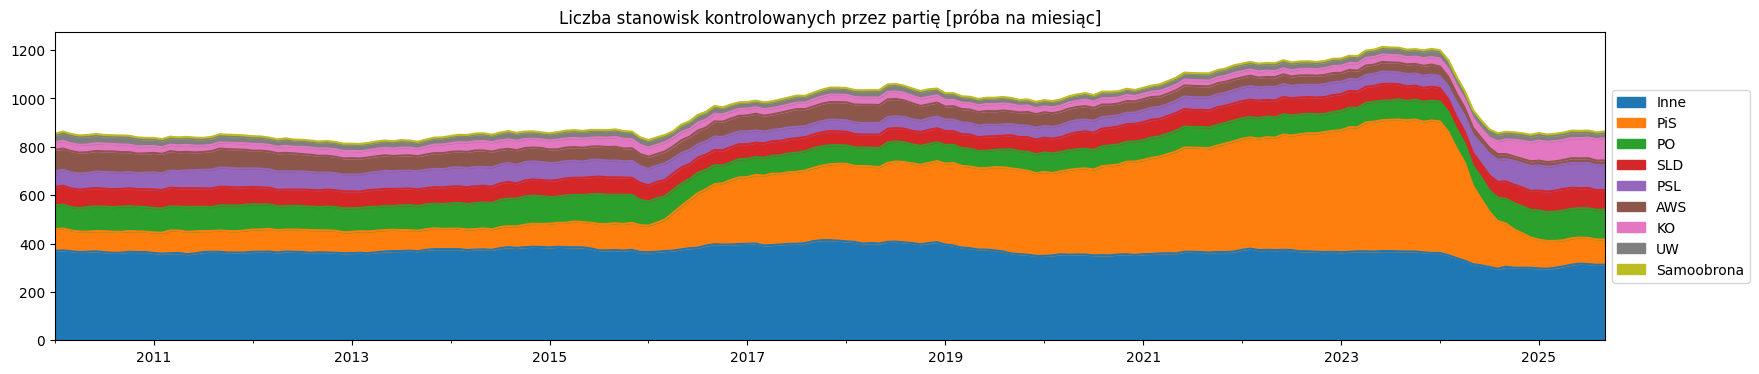

In [8]:
all_parties = set(party for parties in local_good["parties_simplified"].to_list() for party in parties)
local = {
 'Blok Samorządowy Razem',
 'Edward Pietrzyk',
 'Razem dla Radomska',
 'Razem dla Skierniewic',
 'Zbigniew Burzyński',
 'Ziemia Bełchatowska',
 'KWW Plus',
}
parties = all_parties - local
# display(parties)

def party_day_score(row):
    date = row.name
    result = [0] * len(row.index)
    global local_good
    for _i, _row in local_good.iterrows():
        for emp in _row["employment"]:
            duration = timedelta(days=365 * float(emp["employed_for"]))
            start_employed: date = emp["employed_end"] - duration
            if start_employed <= date.date() <= emp["employed_end"]:
                found_a_party = True
                for idx, col in enumerate(row.index):
                    if col in _row["parties_simplified"]:
                        result[idx] += 1
                        break
                else:
                    found_a_party = False
                if not found_a_party:
                    # Add them to "Inne" section
                    result[-1] += 1
    return pd.Series(result)

parties_aggregated = None

def show_graph(unit, unit_name, start='2010/01/01', end='2025/10/01'):
    dates = pd.date_range(start=start, end=end, freq=unit)
    df = pd.DataFrame({
        party: np.random.rand(len(dates)) for party in parties | set(["Inne"])
    }, index=dates)
    # Order dataframe columns by most recent, so we will return only at once
    df = df[["PiS","KO","PO","PSL","SLD",
             #"PO+PiS",
             "Samoobrona","AWS","UW","Inne"]]
    # display(df)
    
    party_stats = pd.DataFrame({}, columns=df.columns)
    party_stats[df.columns] = df.apply(party_day_score, axis=1)
    global parties_aggregated
    parties_aggregated = party_stats.sum(0).sort_values(ascending=False)
    descending_party_popularity = parties_aggregated.index
    party_stats = party_stats[descending_party_popularity]
    # display(party_stats)
    
    ax = party_stats.plot.area(figsize=(20, 4))
    ax.set_title(f"Liczba stanowisk kontrolowanych przez partię [próba na {unit_name}]")
    ax.legend(loc="center left", bbox_to_anchor=(1.0,0.5))

show_graph("ME", "miesiąc")

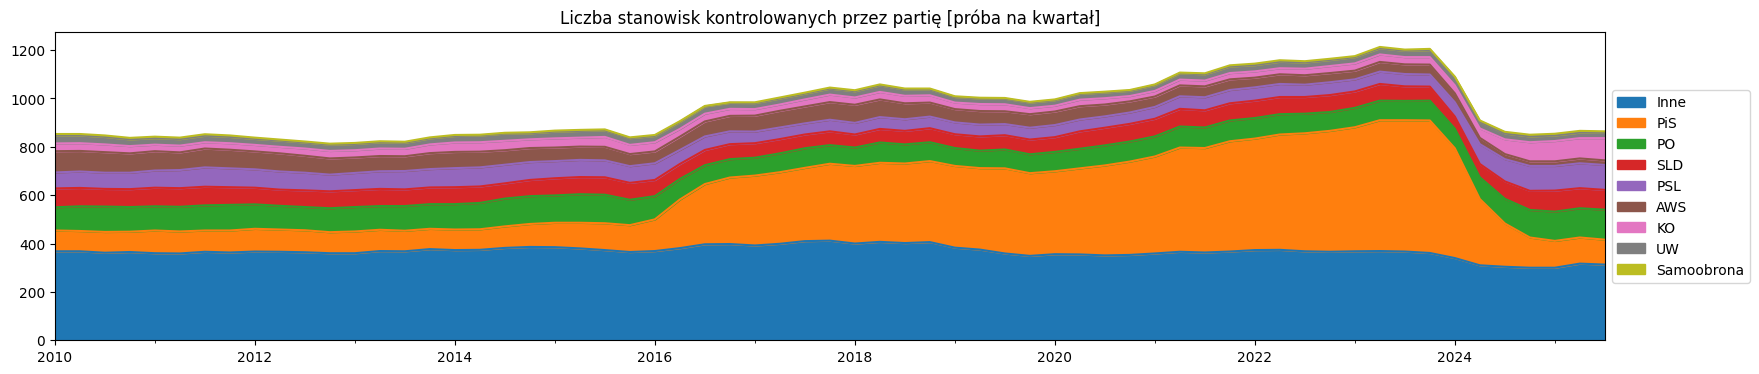

In [9]:
show_graph("QE", "kwartał")

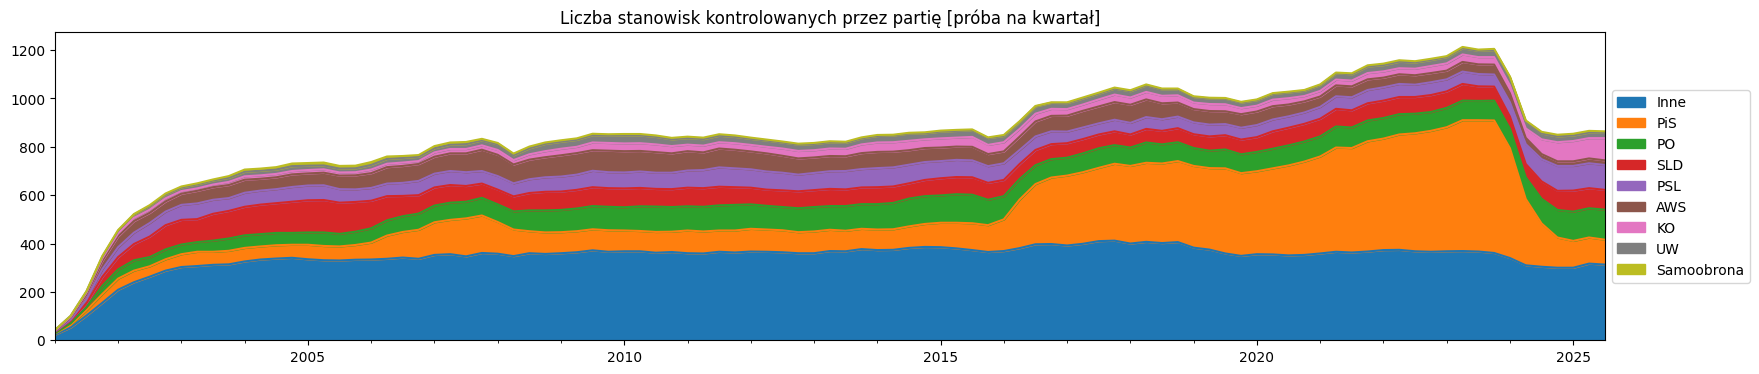

In [10]:
show_graph("QE", "kwartał", start="2001/01/01")

Text(0.5, 1.0, 'Łączny czas kontroli przez partie')

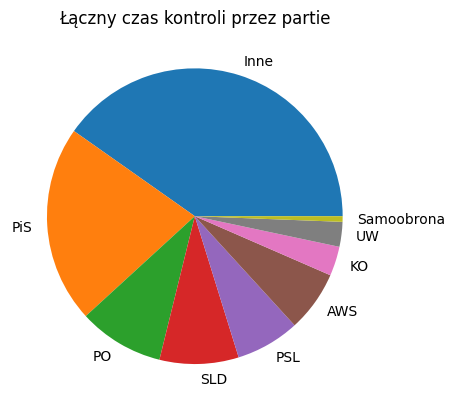

In [11]:
ax = parties_aggregated.plot.pie()
ax.set_title("Łączny czas kontroli przez partie")

Text(0.5, 0, 'Data ostatniego zatrudnienia')

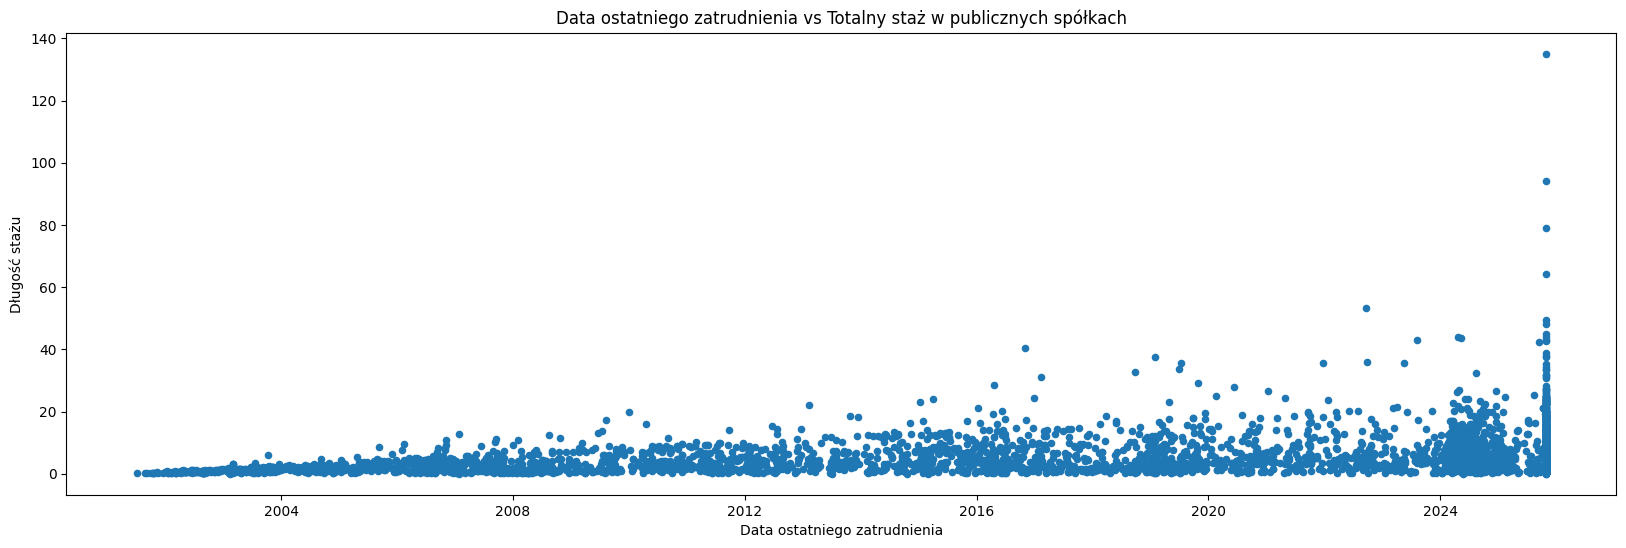

In [12]:
local_good["employed_total_years"] = local_good[("employed_total")].apply(lambda d: d.days / 365)
ax = local_good[["last_employed", "employed_total_years"]].plot.scatter(x="last_employed", y="employed_total_years", style=".", figsize=(20, 6))
ax.set_title("Data ostatniego zatrudnienia vs Totalny staż w publicznych spółkach")
ax.set_ylabel("Długość stażu")
ax.set_xlabel("Data ostatniego zatrudnienia")

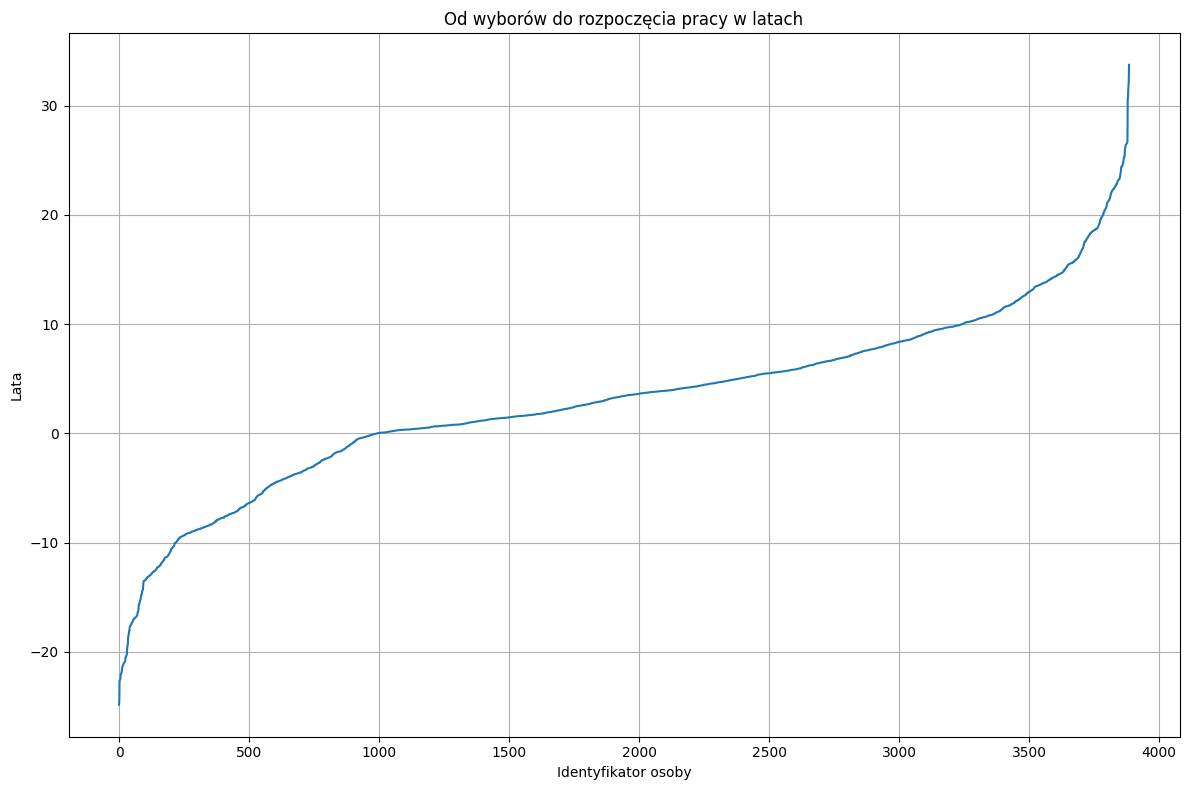

In [13]:
plt.figure(figsize=(12, 8))
ax = local_good["election_before_work"].apply(lambda duration: duration.days / 365).plot()
ax.set_xlabel("Identyfikator osoby")
ax.set_ylabel("Lata")
ax.grid(True)
ax.set_title("Od wyborów do rozpoczęcia pracy w latach")
plt.tight_layout()
plt.show()

In [14]:
d = date(year=1, month=1, day=1)
zero_delta = d - d

local_good["election_before_work_years"] = local_good["election_before_work"].apply(lambda d: d.days / 365)
longest_dur = local_good["election_before_work_years"].max()  # Use it, to put negative values after positive values of this column
local_good["election_before_work_normalized"] = local_good["election_before_work_years"].apply(lambda d: -d + longest_dur if d < 0 else d)

def calculate_position(column, smallest_good):
    # print(column)
    sort_series = local_good[column].sort_values(ascending=smallest_good)
    # display(sort_series)
    index_position = pd.Series(index=sort_series.index, data=range(len(sort_series)))
    # display(index_position)
    index_ordered = index_position.sort_index()
    # display(index_ordered)
    return index_ordered

a = calculate_position("election_before_work_normalized", smallest_good=True)
b = calculate_position("mistake_odds", smallest_good=False)
c = calculate_position("employed_total_years", smallest_good=False)
d = calculate_position("first_employed", smallest_good=False)
e = calculate_position("last_employed", smallest_good=False)

local_good["position"] = a + b + c + d + e
local_good.sort_values(by="position", inplace=True)

polish_headers = ["Pozycja", "Imię i nazwisko", "Data urodzenia", "Szansa na błąd - jeden na ...", "Od wyborów do pracy [lata]", "Łączny staż [lata]", "Pierwsze zatrudnienie", "Ostatnie zatrudnienie", "Historia"]
cleaned = pd.DataFrame({}, columns=polish_headers)
cleaned[polish_headers] = local_good[["position", "krs_name", "birth_date", "mistake_odds", "election_before_work_years", "employed_total_years", "first_employed", "last_employed", "history"]]

display(cleaned.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None)

In [15]:
# Write to output
local_output = versioned.get_path(f"people_woj_{teryt}.csv")
cleaned.to_csv(local_output,index=False)

# Write to output
companies_output = versioned.get_path(f"companies_woj_{teryt}.csv")
local_companies.to_csv(companies_output,index=False)